Using file: /usr2/people/shollyt22/shollyt22/RNASeq/GO_term_significant ones.csv


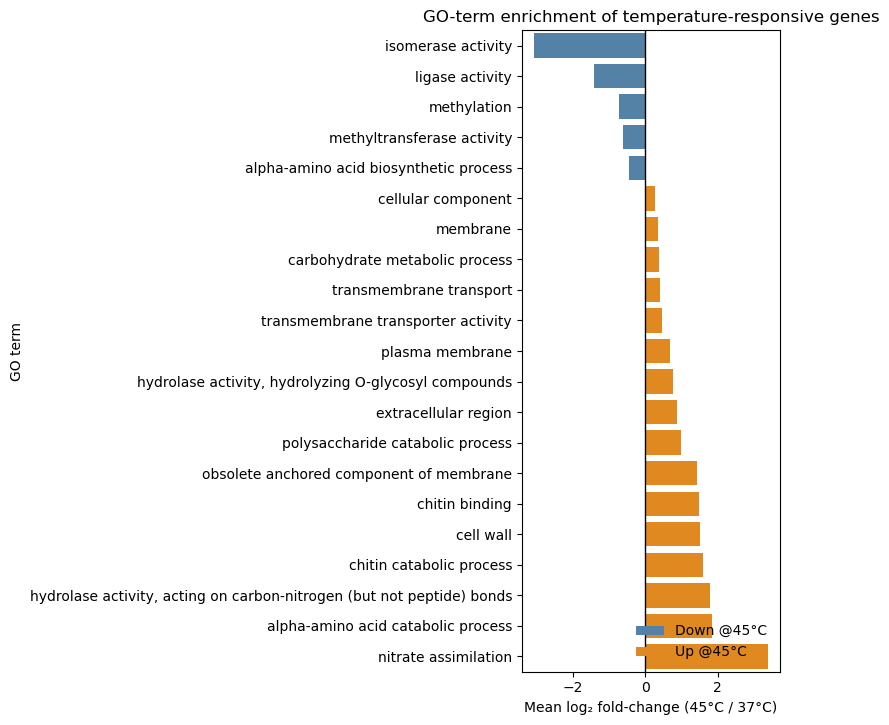

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import shorten
from pathlib import Path

# ---- CONFIG: your expected file (used as a hint) ----
HINT_PATH = "/usr2/people/shollyt22/shollyt22/RNASeq/GO_term_significant_ones.csv"
FC_COL = "Observed_Mean_log2FoldChange"

# ---- 1) Locate the file robustly ----
p = Path(HINT_PATH)
search_base = p.parent if p.parent.as_posix() else Path.cwd()

if not search_base.exists():
    raise FileNotFoundError(f"Directory not found: {search_base}")

def find_file():
    if p.exists():
        return p
    # Try likely patterns in the same folder
    patterns = [
        p.name,                         # exact name
        f"{p.stem}.*",                  # any extension
        "*GO*term*significant*.*",
        "*GO*significant*.*",
        "*GO*significant*",
    ]
    cands = []
    for pat in patterns:
        cands += list(search_base.glob(pat))
    # If still nothing, search recursively under RNASeq dir
    if not cands:
        cands = list(search_base.rglob("*GO*significant*"))
    if not cands:
        raise FileNotFoundError(
            "Could not find the GO-term file. "
            f"Tried in: {search_base}\n"
            "Tip: run `!ls -lah /usr2/people/shollyt22/shollyt22/RNASeq` in a cell to inspect."
        )
    # Pick the most recently modified match
    cands.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    return cands[0]

FILE = find_file()
print(f"Using file: {FILE}")

# ---- 2) Load (csv/tsv) ----
suffix = FILE.suffix.lower()
sep = "," if suffix == ".csv" else "\t" if suffix in {".tsv", ".tab"} else None
if sep is None:
    # fall back to Python engine dialect sniffing
    df = pd.read_csv(FILE, engine="python")
else:
    df = pd.read_csv(FILE, sep=sep)

# ---- 3) Clean rows: keep real GO IDs ----
go_col = "GO_ID" if "GO_ID" in df.columns else "GO Id" if "GO Id" in df.columns else None
if not go_col:
    # try to auto-detect a GO-like column
    for c in df.columns:
        if df[c].astype(str).str.startswith("GO:").any():
            go_col = c
            break
if not go_col:
    raise KeyError("Couldn't find a GO ID column. Make sure there is a column with values like 'GO:0008150'.")

df = df[df[go_col].astype(str).str.startswith("GO:")].copy()

# ---- 4) Effect-size column: ensure 1-D Series even if duplicates exist ----
if (df.columns == FC_COL).sum() > 1:
    fc_series = df.loc[:, df.columns == FC_COL].iloc[:, 0]
elif FC_COL in df.columns:
    fc_series = df[FC_COL]
else:
    # try common variants
    alt_names = [c for c in df.columns if "log2" in c.lower() and "fold" in c.lower()]
    if not alt_names:
        raise KeyError(f"Column '{FC_COL}' not found, and no obvious log2 fold-change column detected.")
    FC_COL = alt_names[0]
    fc_series = df[FC_COL]

df[FC_COL] = pd.to_numeric(fc_series, errors="coerce")
df = df.dropna(subset=[FC_COL])

# ---- 5) Description column ----
desc_col = "Description" if "Description" in df.columns else None
if not desc_col:
    # try to guess a human-readable label column
    for c in ["Term", "Name", "GO_Term", "go_term", "Desc"]:
        if c in df.columns:
            desc_col = c
            break
if not desc_col:
    raise KeyError("Couldn't find a description column (e.g., 'Description', 'Term').")

# Shorten long labels (keeps readable y-axis)
df[desc_col] = df[desc_col].astype(str).map(lambda s: shorten(s, width=80, placeholder="…"))

# ---- 6) Sort and preserve order ----
df = df.sort_values(FC_COL, ascending=True)
df[desc_col] = pd.Categorical(df[desc_col], categories=df[desc_col], ordered=True)

# ---- 7) Direction for hue (use a column name → avoids 2-D hue bug) ----
df["Direction"] = pd.Series(["Up @45°C" if v > 0 else "Down @45°C" for v in df[FC_COL]], index=df.index)

# ---- 8) Plot ----
plt.figure(figsize=(8, max(4, 0.35 * len(df))))
ax = sns.barplot(
    data=df,
    x=FC_COL,
    y=desc_col,
    hue="Direction",
    dodge=False,
    palette={"Up @45°C": "darkorange", "Down @45°C": "steelblue"},
    edgecolor="none"
)
ax.axvline(0, color="k", lw=1)
ax.set_xlabel("Mean log₂ fold-change (45°C / 37°C)")
ax.set_ylabel("GO term")
ax.set_title("GO-term enrichment of temperature-responsive genes")
ax.legend(title=None, frameon=False, loc="lower right")
plt.tight_layout()
plt.show()


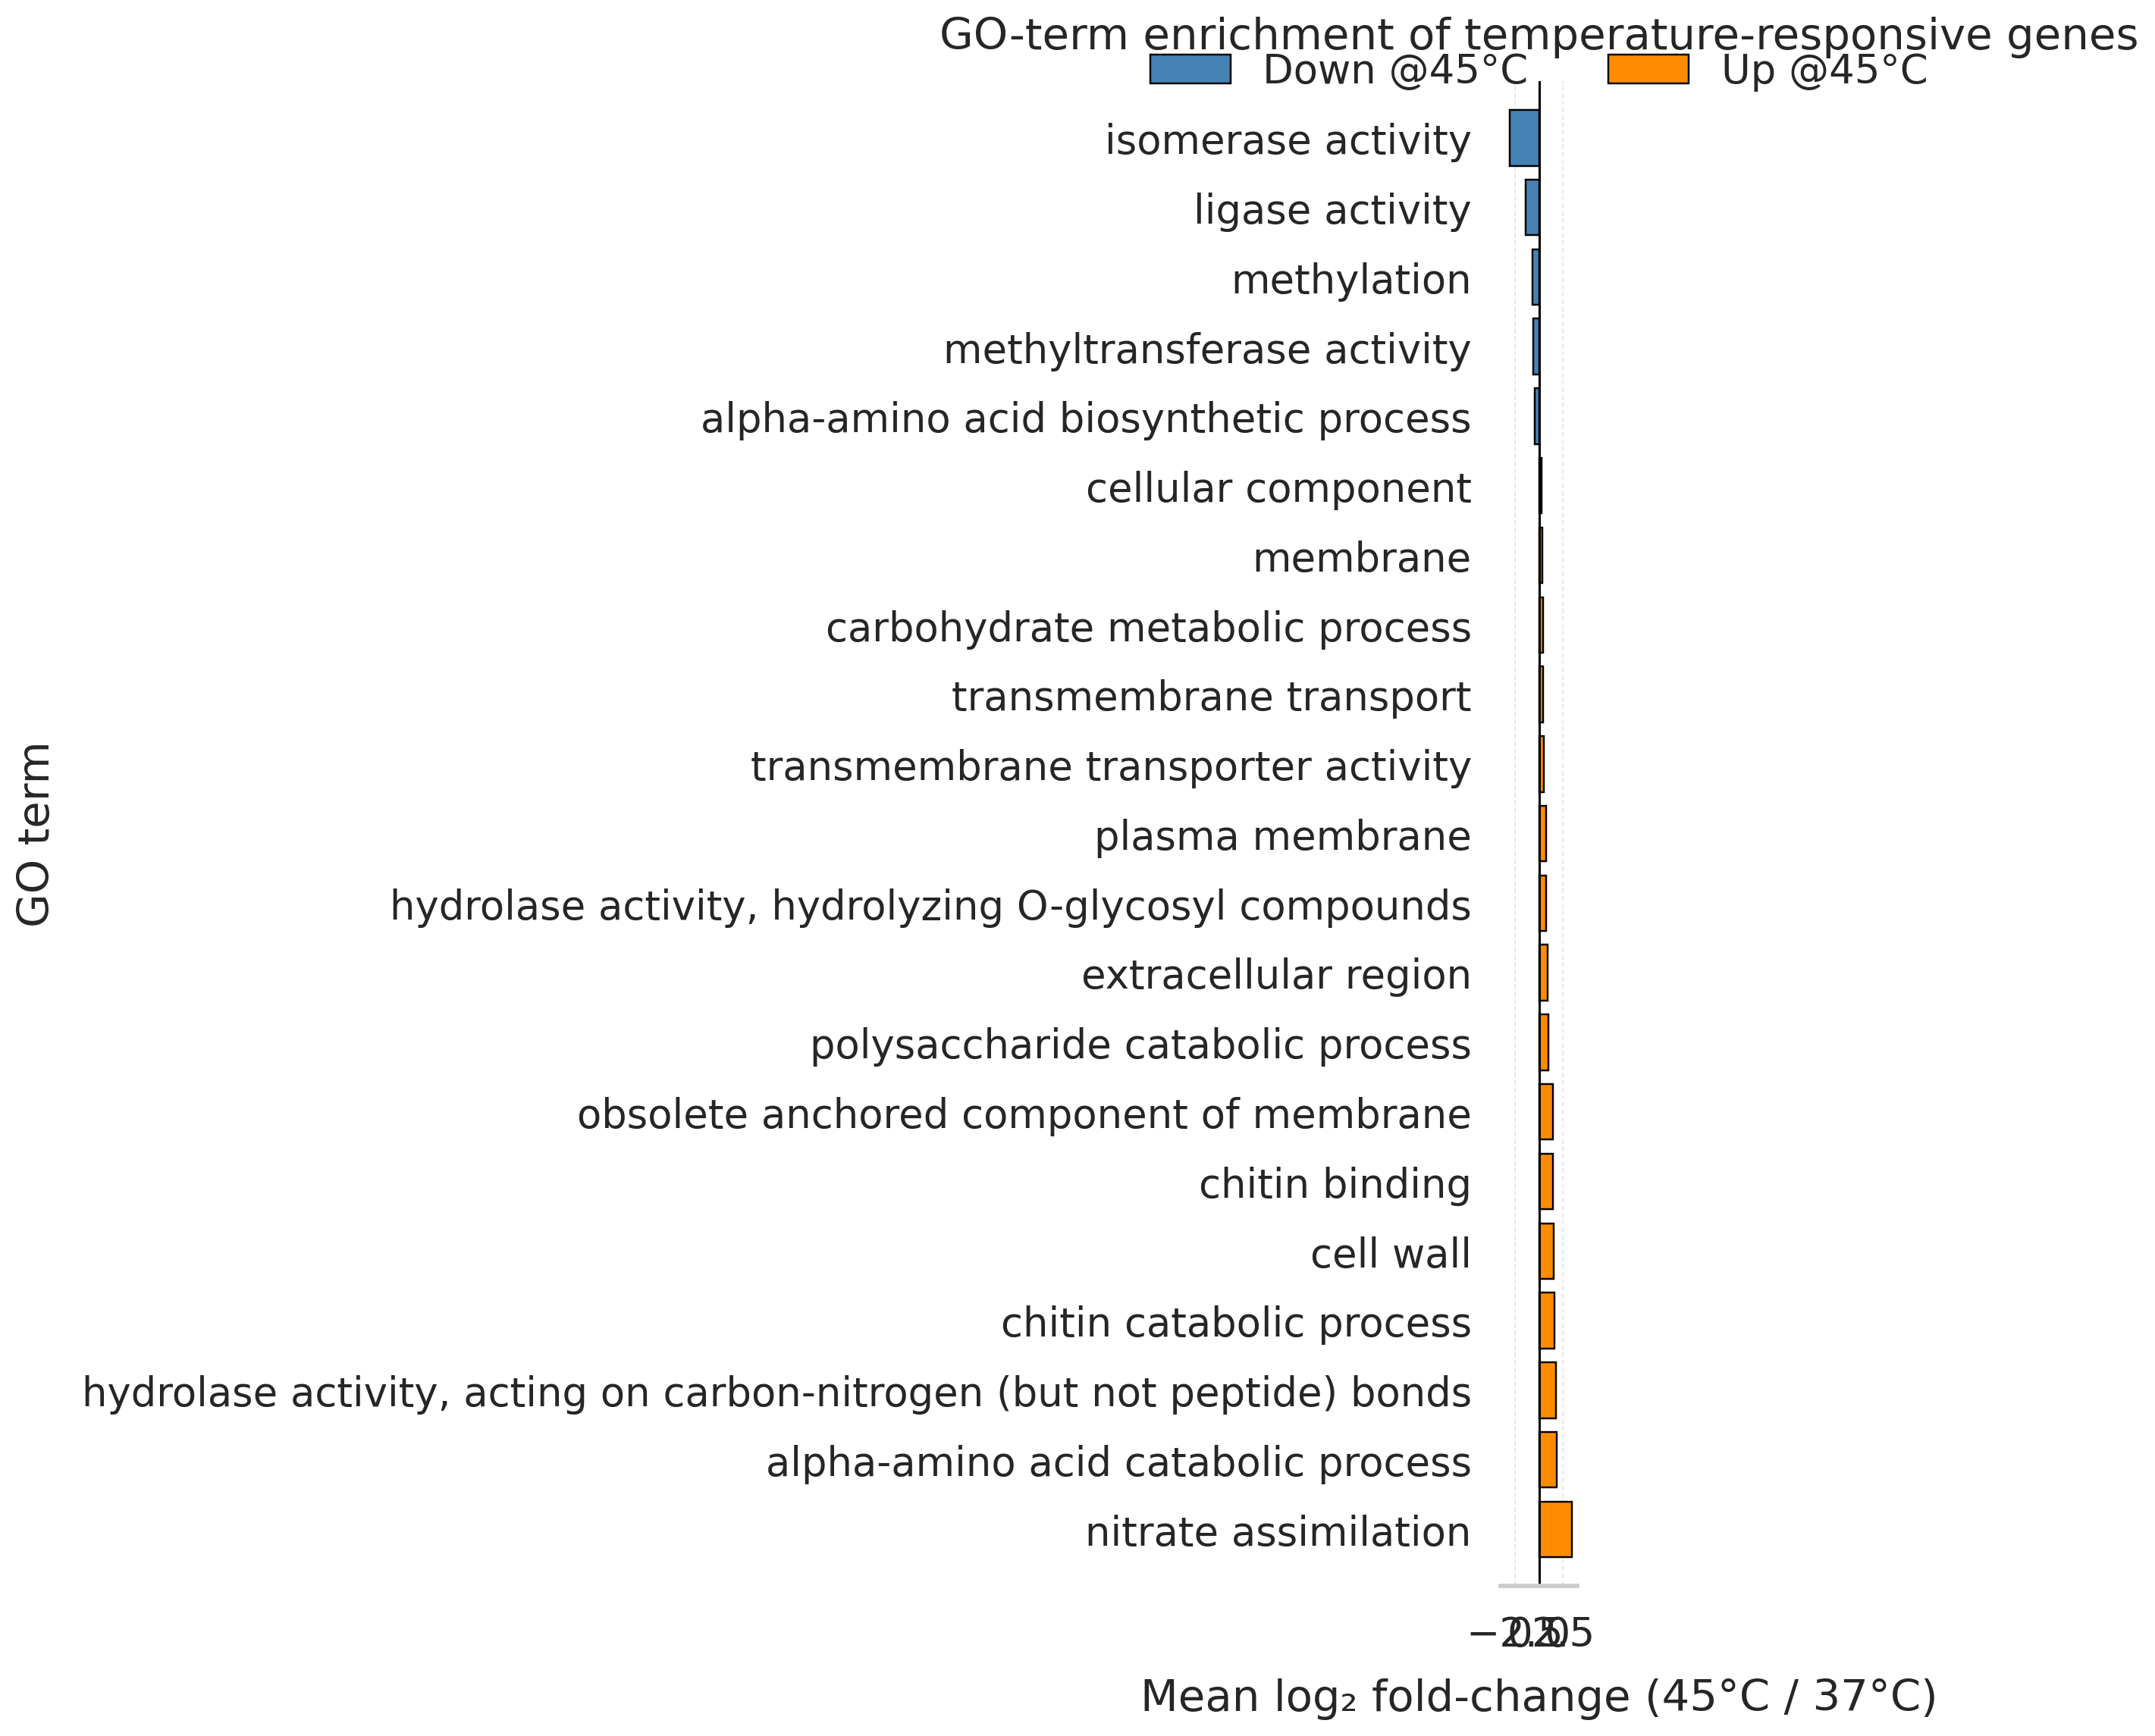

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

FC_COL = "Observed_Mean_log2FoldChange"

# (Optional) show only the strongest terms to avoid clutter
# N = 20
# df = pd.concat([df.nsmallest(N, FC_COL), df.nlargest(N, FC_COL)])

# Order by effect size so negatives (down) are at top
df = df.sort_values(FC_COL, ascending=True).copy()
df["Description"] = pd.Categorical(df["Description"], categories=df["Description"], ordered=True)
df["Direction"] = np.where(df[FC_COL] > 0, "Up @45°C", "Down @45°C")

# --- Styling for clarity & print quality ---
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.05)   # larger fonts

# Compute symmetric x-limits for balance
m = float(df[FC_COL].abs().max())
xmax = np.ceil(m * 1.1)

fig, ax = plt.subplots(figsize=(10, 11), dpi=220)  # bigger + higher DPI

# Solid bars with clear edges
sns.barplot(
    data=df,
    x=FC_COL, y="Description",
    hue="Direction", dodge=False,
    palette={"Up @45°C": "darkorange", "Down @45°C": "steelblue"},
    edgecolor="black", linewidth=0.8, saturation=1.0, ax=ax
)

# Grid & zero-line
ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
ax.axvline(0, color="black", lw=1)

# Axis limits & spacing
ax.set_xlim(-xmax, xmax)
plt.margins(y=0.02)

# Labels/titles (note: no space before °C as you prefer)
ax.set_xlabel("Mean log₂ fold-change (45°C / 37°C)", labelpad=10)
ax.set_ylabel("GO term", labelpad=10)
ax.set_title("GO-term enrichment of temperature-responsive genes", pad=14)

# Legend on top, compact, no frame
leg = ax.legend(
    title=None, frameon=False, ncol=2,
    loc="upper center", bbox_to_anchor=(0.5, 1.03), borderaxespad=0.0
)

# Reduce visual clutter
sns.despine(left=True, bottom=False)

# Tight but leave room for top legend
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save high-res outputs
plt.savefig("GO_terms_enrichment.png", dpi=300, bbox_inches="tight")
plt.savefig("GO_terms_enrichment.svg", bbox_inches="tight")
plt.show()


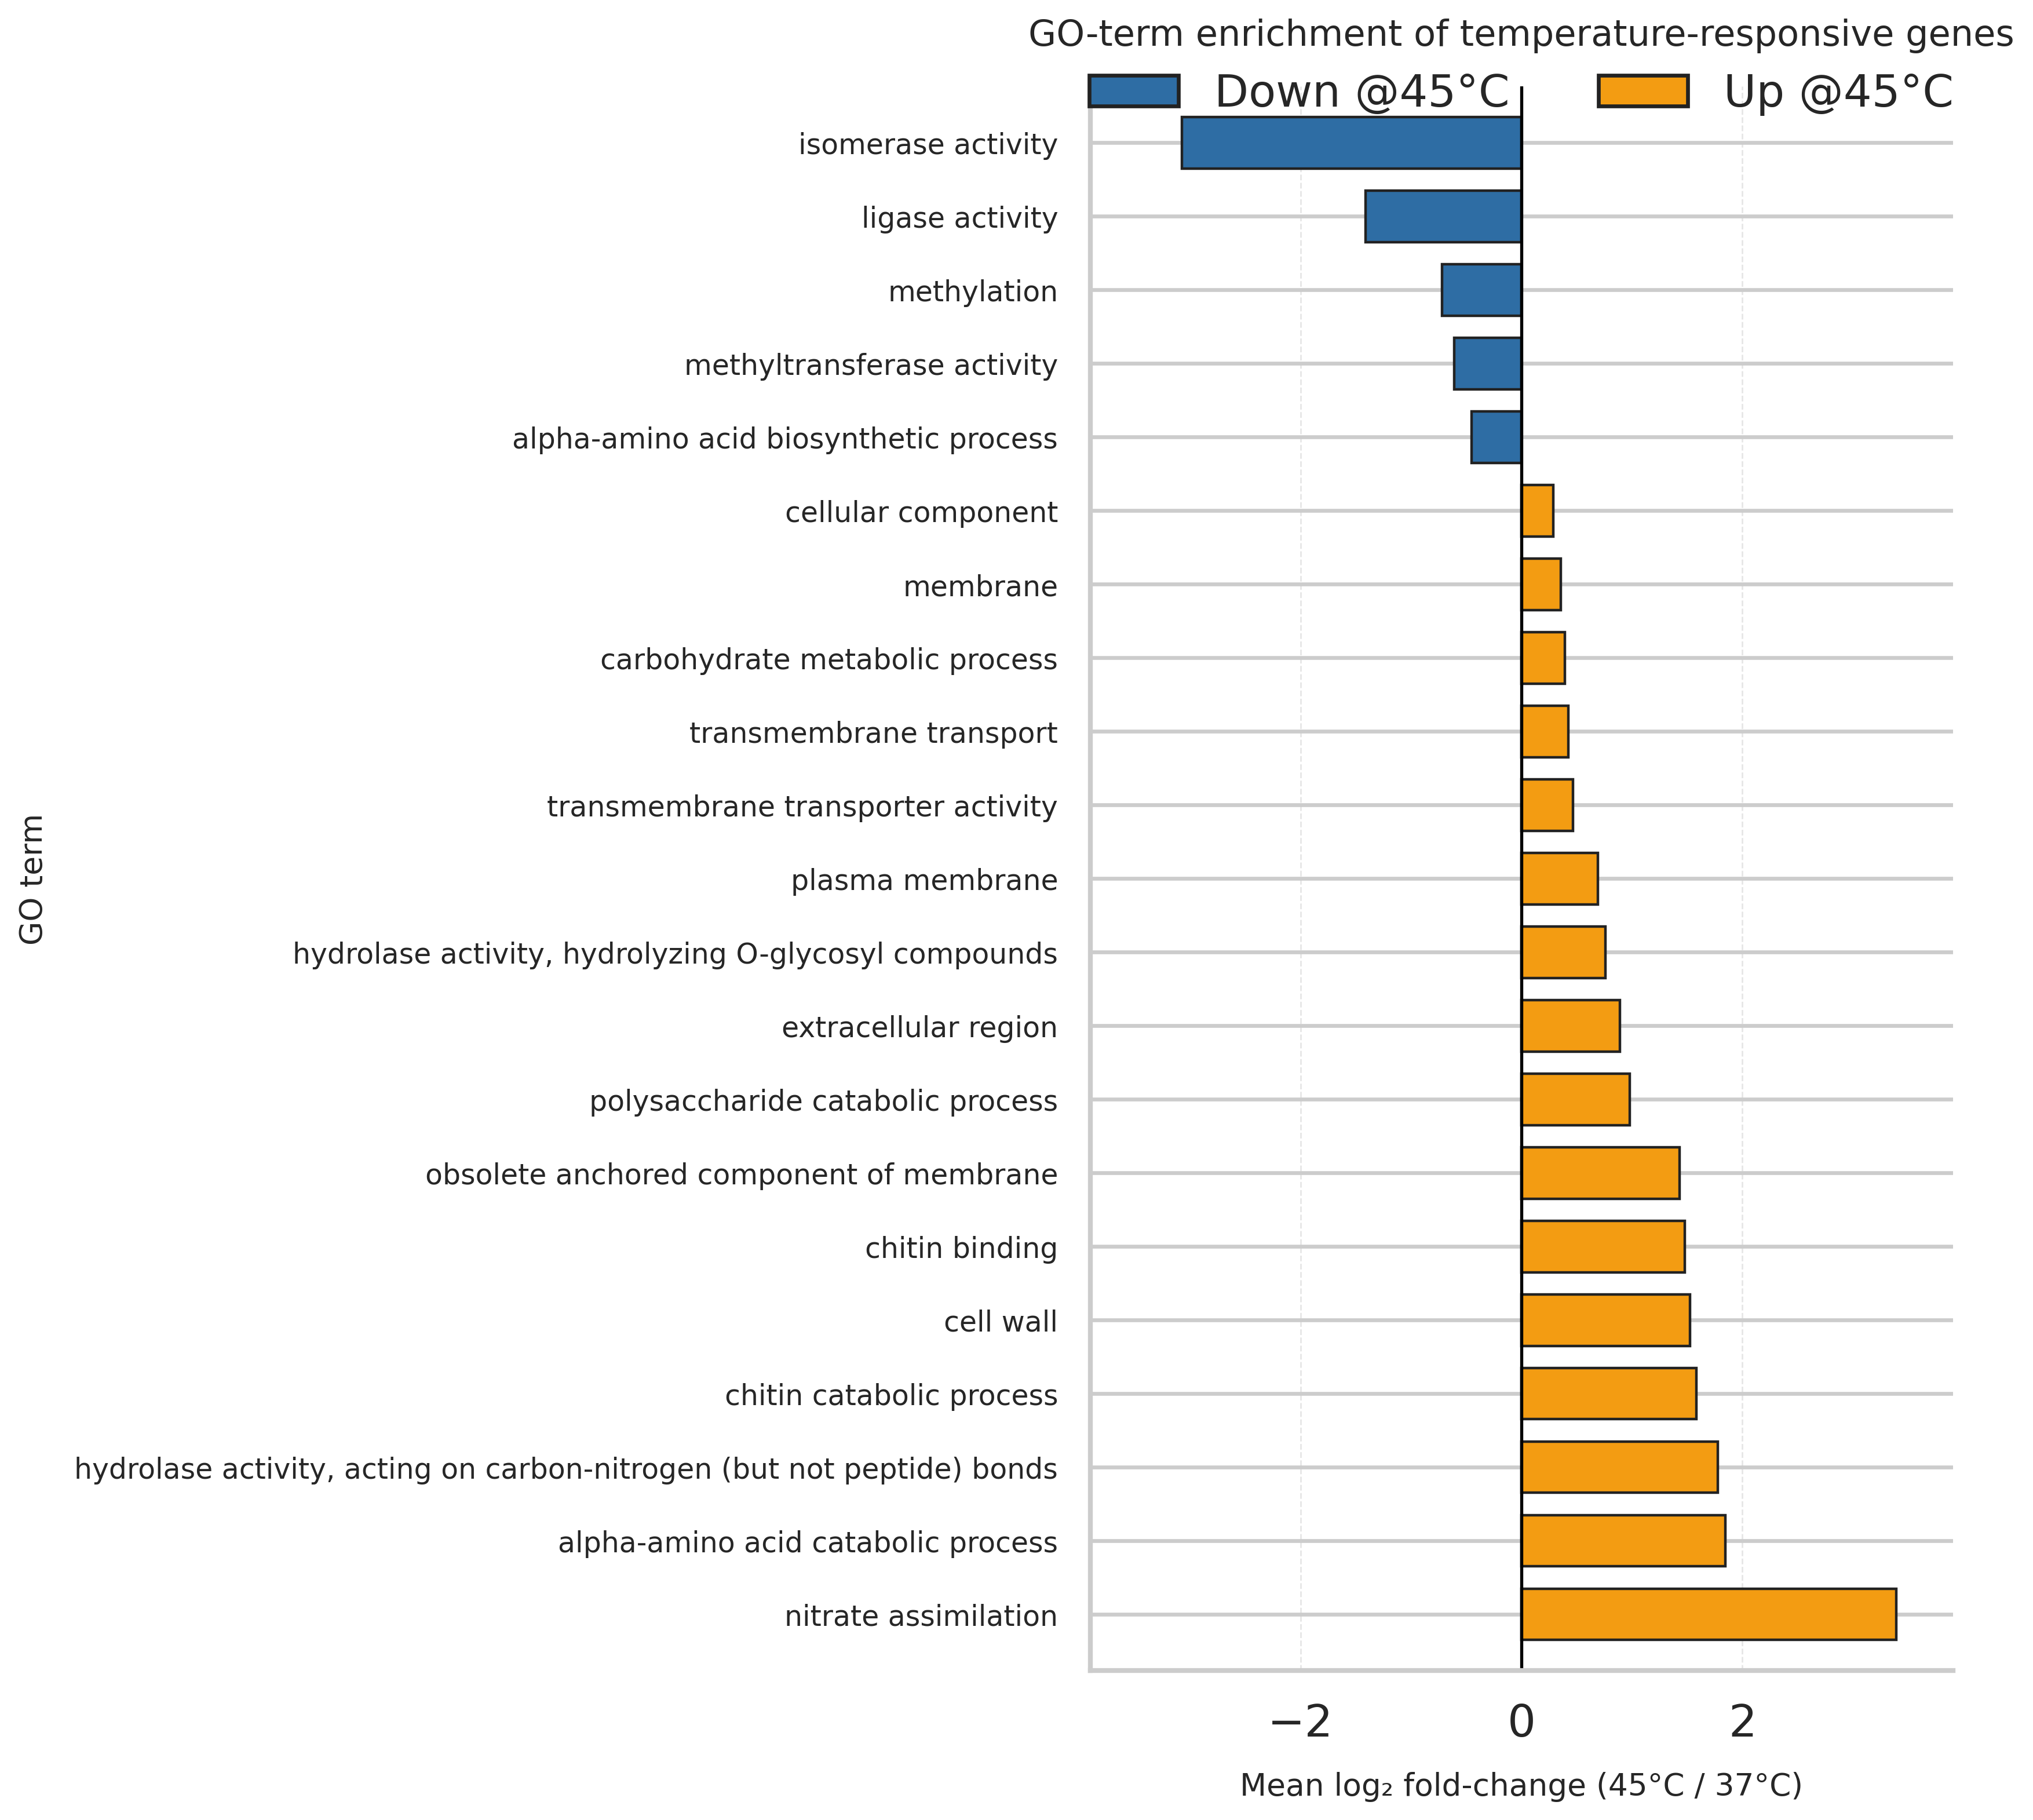

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

FC_COL = "Observed_Mean_log2FoldChange"

# --- (Optional) keep strongest terms by |log2FC| to avoid clutter ---
# top_n = 20
# df = df.reindex(df[FC_COL].abs().sort_values(ascending=False).head(top_n).index)

# Sort so negatives at top, positives at bottom (nice flow around zero)
df = df.sort_values(FC_COL, ascending=True).copy()

desc = df["Description"].astype(str).tolist()
vals = df[FC_COL].to_numpy()

# Colors by direction (customizable)
colors = np.where(vals >= 0, "#f39c12", "#2e6da4")  # orange / steel blue
edge = "#222222"

# --- Figure: large, high DPI, generous margins ---
bar_height = 0.7                                   # thicker bars
h = max(6, 0.5 * len(df))                          # scale height with rows
fig, ax = plt.subplots(figsize=(11, h), dpi=320)

# Horizontal bars with solid edges
ypos = np.arange(len(df))
ax.barh(
    ypos, vals,
    height=bar_height,
    color=colors,
    edgecolor=edge,
    linewidth=1.0
)

# Zero line + x-grid
ax.axvline(0, color="black", linewidth=1.2)
ax.xaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.set_axisbelow(True)

# Symmetric x-lims for balance with padding
m = float(np.nanmax(np.abs(vals))) if len(vals) else 1.0
pad = max(0.2, m * 0.15)                           # visible breathing room
ax.set_xlim(-m - pad, m + pad)

# Y labels & spacing
ax.set_yticks(ypos)
ax.set_yticklabels(desc, fontsize=11)
ax.invert_yaxis()                                   # highest (most negative) on top
ax.margins(y=0.02)

# Labels & title (per your °C style)
ax.set_xlabel("Mean log₂ fold-change (45°C / 37°C)", fontsize=12, labelpad=10)
ax.set_ylabel("GO term", fontsize=12, labelpad=10)
ax.set_title("GO-term enrichment of temperature-responsive genes", fontsize=14, pad=16)

# Legend on top (no frame)
handles = [
    Patch(facecolor="#2e6da4", edgecolor=edge, label="Down @45°C"),
    Patch(facecolor="#f39c12", edgecolor=edge, label="Up @45°C"),
]
ax.legend(
    handles=handles, title=None, frameon=False, ncol=2,
    loc="upper center", bbox_to_anchor=(0.5, 1.02), borderaxespad=0.0
)

# Clean spines and tighten layout
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# High-res exports (PNG + vector)
plt.savefig("GO_terms_enrichment.png", dpi=400, bbox_inches="tight")
plt.savefig("GO_terms_enrichment.svg", bbox_inches="tight")
plt.show()


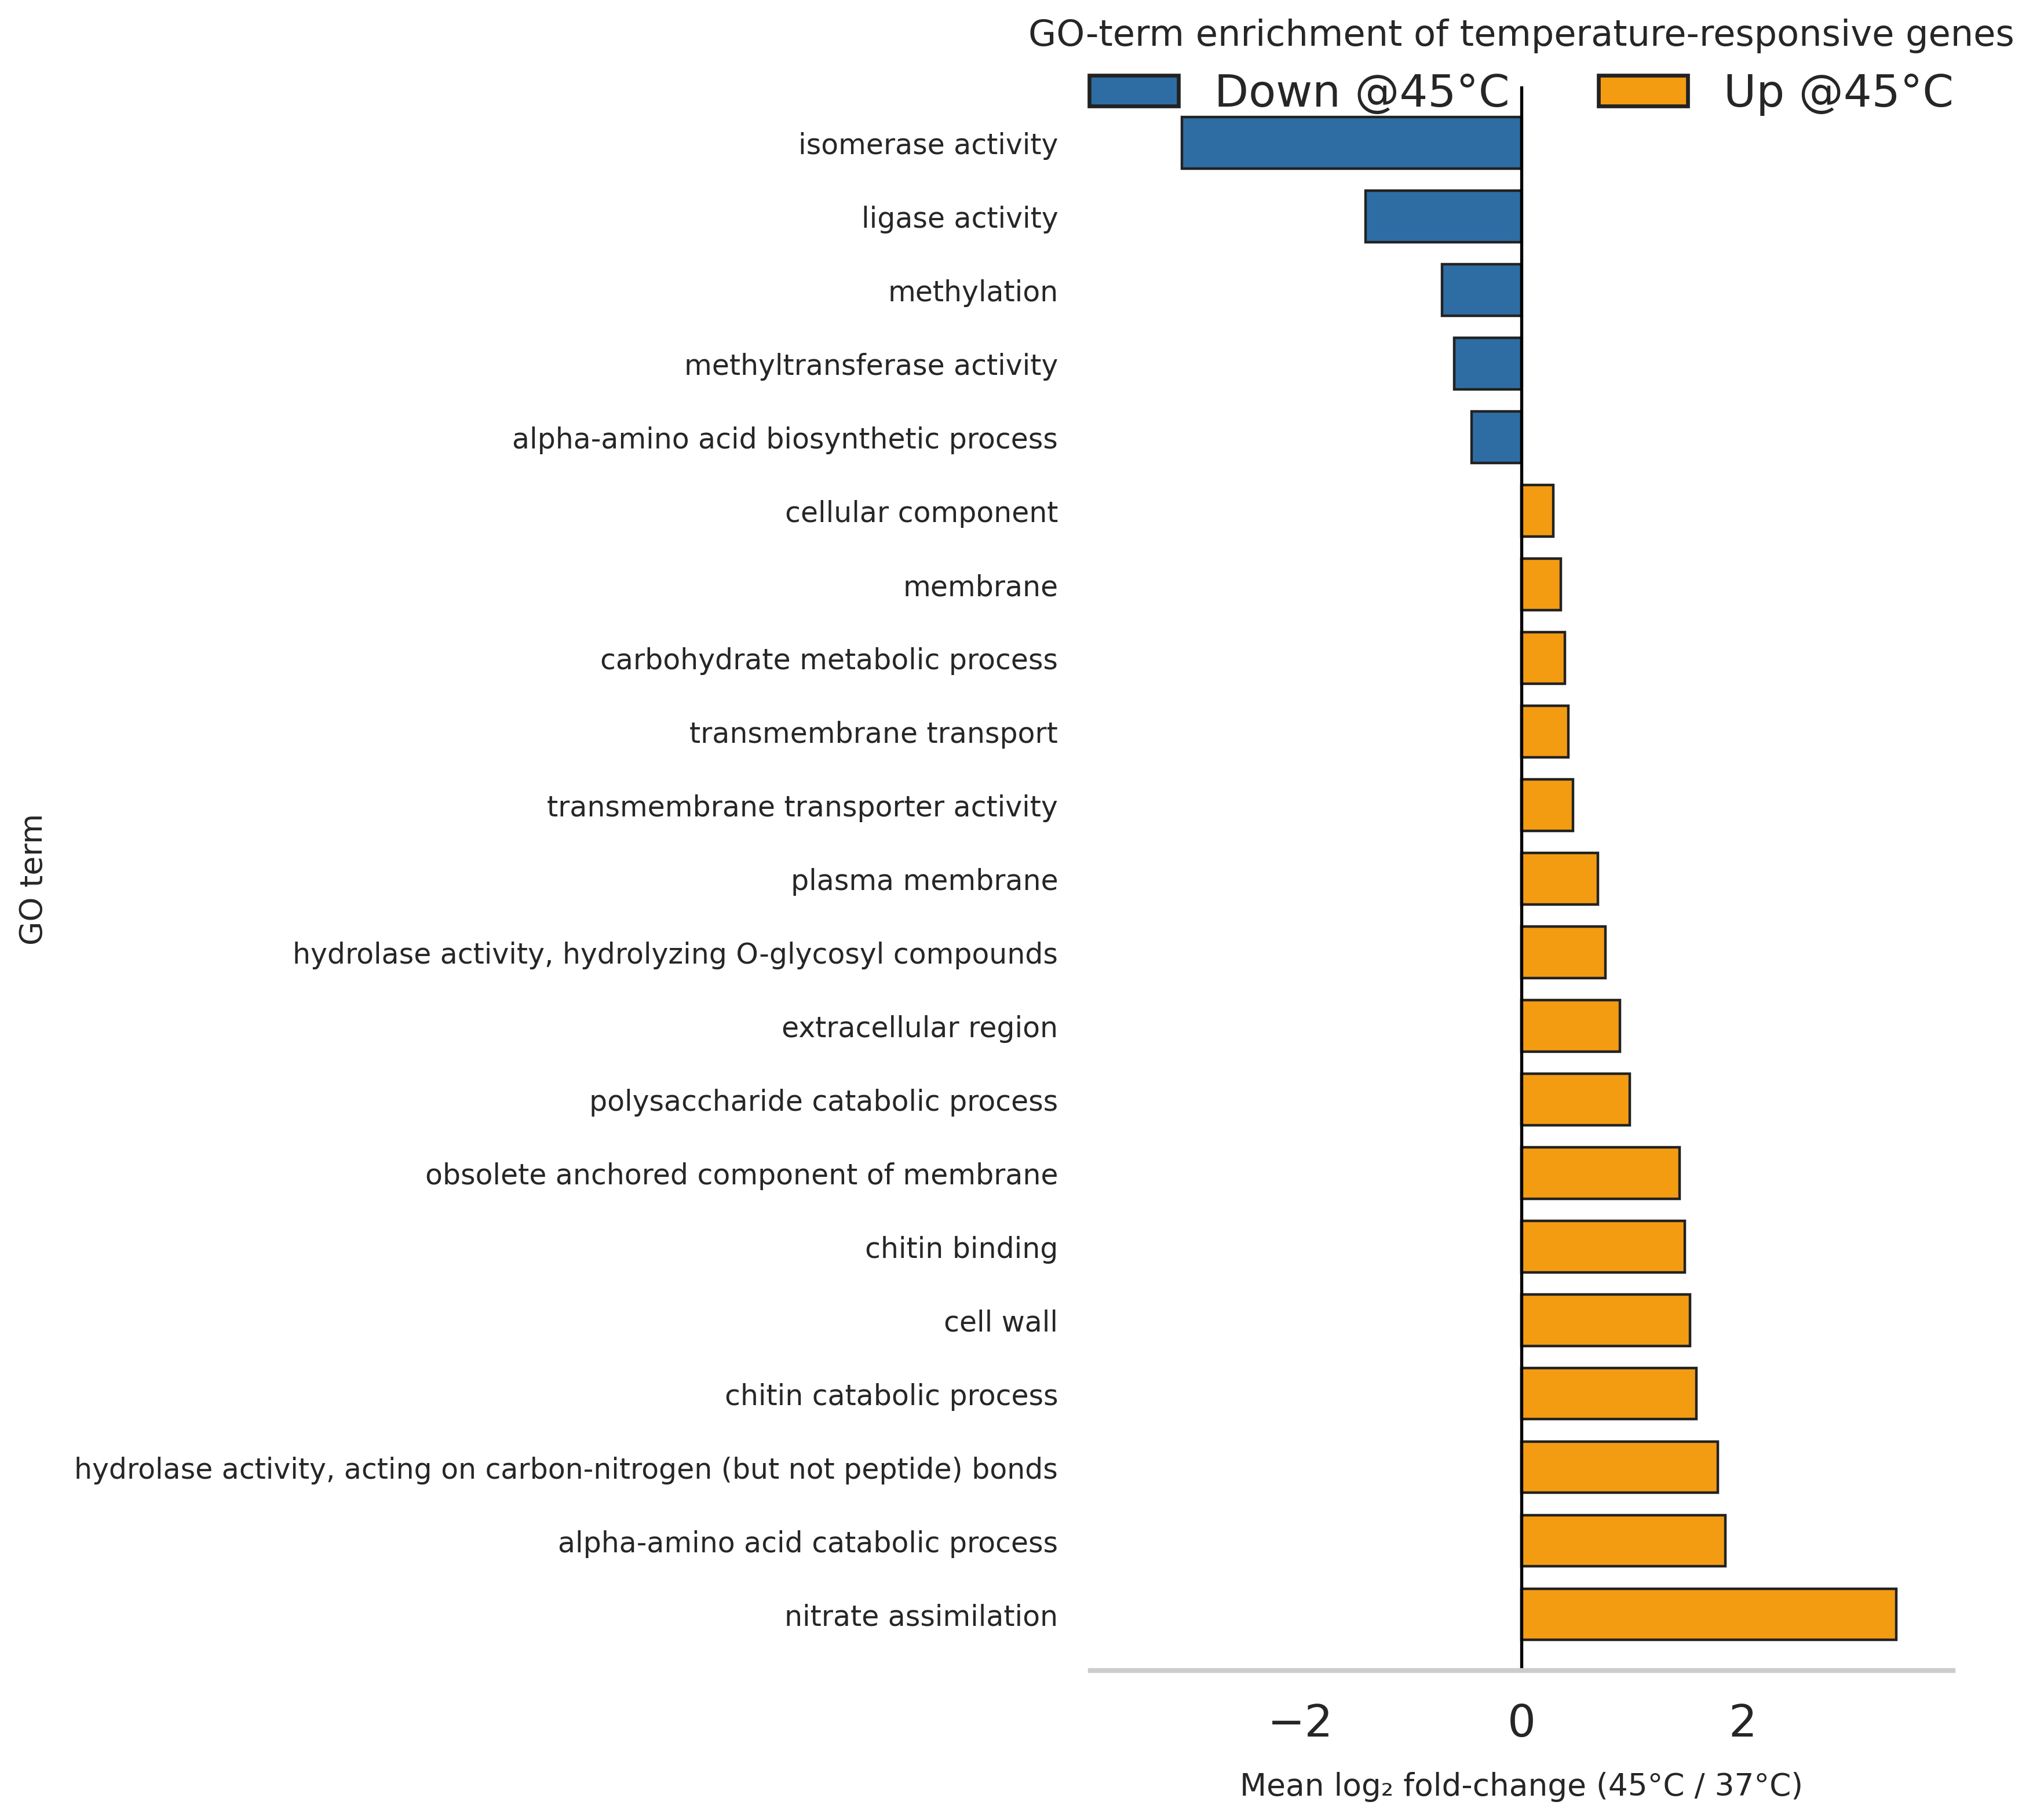

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# === Configuration ===
FC_COL = "Observed_Mean_log2FoldChange"

# --- Optional: select strongest terms by |log2FC| ---
# top_n = 20
# df = df.reindex(df[FC_COL].abs().sort_values(ascending=False).head(top_n).index)

# --- Sort for plotting (negatives at top, positives at bottom) ---
df = df.sort_values(FC_COL, ascending=True).copy()
desc = df["Description"].astype(str).tolist()
vals = df[FC_COL].to_numpy()

# --- Colors and styling ---
colors = np.where(vals >= 0, "#f39c12", "#2e6da4")   # orange / blue
edge = "#222222"

# --- Figure setup: high DPI, large, generous spacing ---
bar_height = 0.7
h = max(6, 0.5 * len(df))                           # scale height with number of rows
fig, ax = plt.subplots(figsize=(11, h), dpi=320)

# --- Plot horizontal bars ---
ypos = np.arange(len(df))
ax.barh(
    ypos, vals,
    height=bar_height,
    color=colors,
    edgecolor=edge,
    linewidth=1.0
)

# --- Zero line only (no inner grids) ---
ax.axvline(0, color="black", linewidth=1.2)
ax.grid(False)

# --- Symmetric x-axis limits ---
m = float(np.nanmax(np.abs(vals))) if len(vals) else 1.0
pad = max(0.2, m * 0.15)
ax.set_xlim(-m - pad, m + pad)

# --- Y-axis labels ---
ax.set_yticks(ypos)
ax.set_yticklabels(desc, fontsize=11)
ax.invert_yaxis()                                   # highest (most negative) on top
ax.margins(y=0.02)

# --- Axis titles and main title ---
ax.set_xlabel("Mean log₂ fold-change (45°C / 37°C)", fontsize=12, labelpad=10)
ax.set_ylabel("GO term", fontsize=12, labelpad=10)
ax.set_title("GO-term enrichment of temperature-responsive genes", fontsize=14, pad=16)

# --- Legend on top ---
handles = [
    Patch(facecolor="#2e6da4", edgecolor=edge, label="Down @45°C"),
    Patch(facecolor="#f39c12", edgecolor=edge, label="Up @45°C"),
]
ax.legend(
    handles=handles, title=None, frameon=False, ncol=2,
    loc="upper center", bbox_to_anchor=(0.5, 1.02), borderaxespad=0.0
)

# --- Clean up spines (remove top, right, and left) ---
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# --- Save high-quality images (PNG + SVG) ---
plt.savefig("GO_terms_enrichment.png", dpi=400, bbox_inches="tight")
plt.savefig("GO_terms_enrichment.svg", bbox_inches="tight")
plt.show()


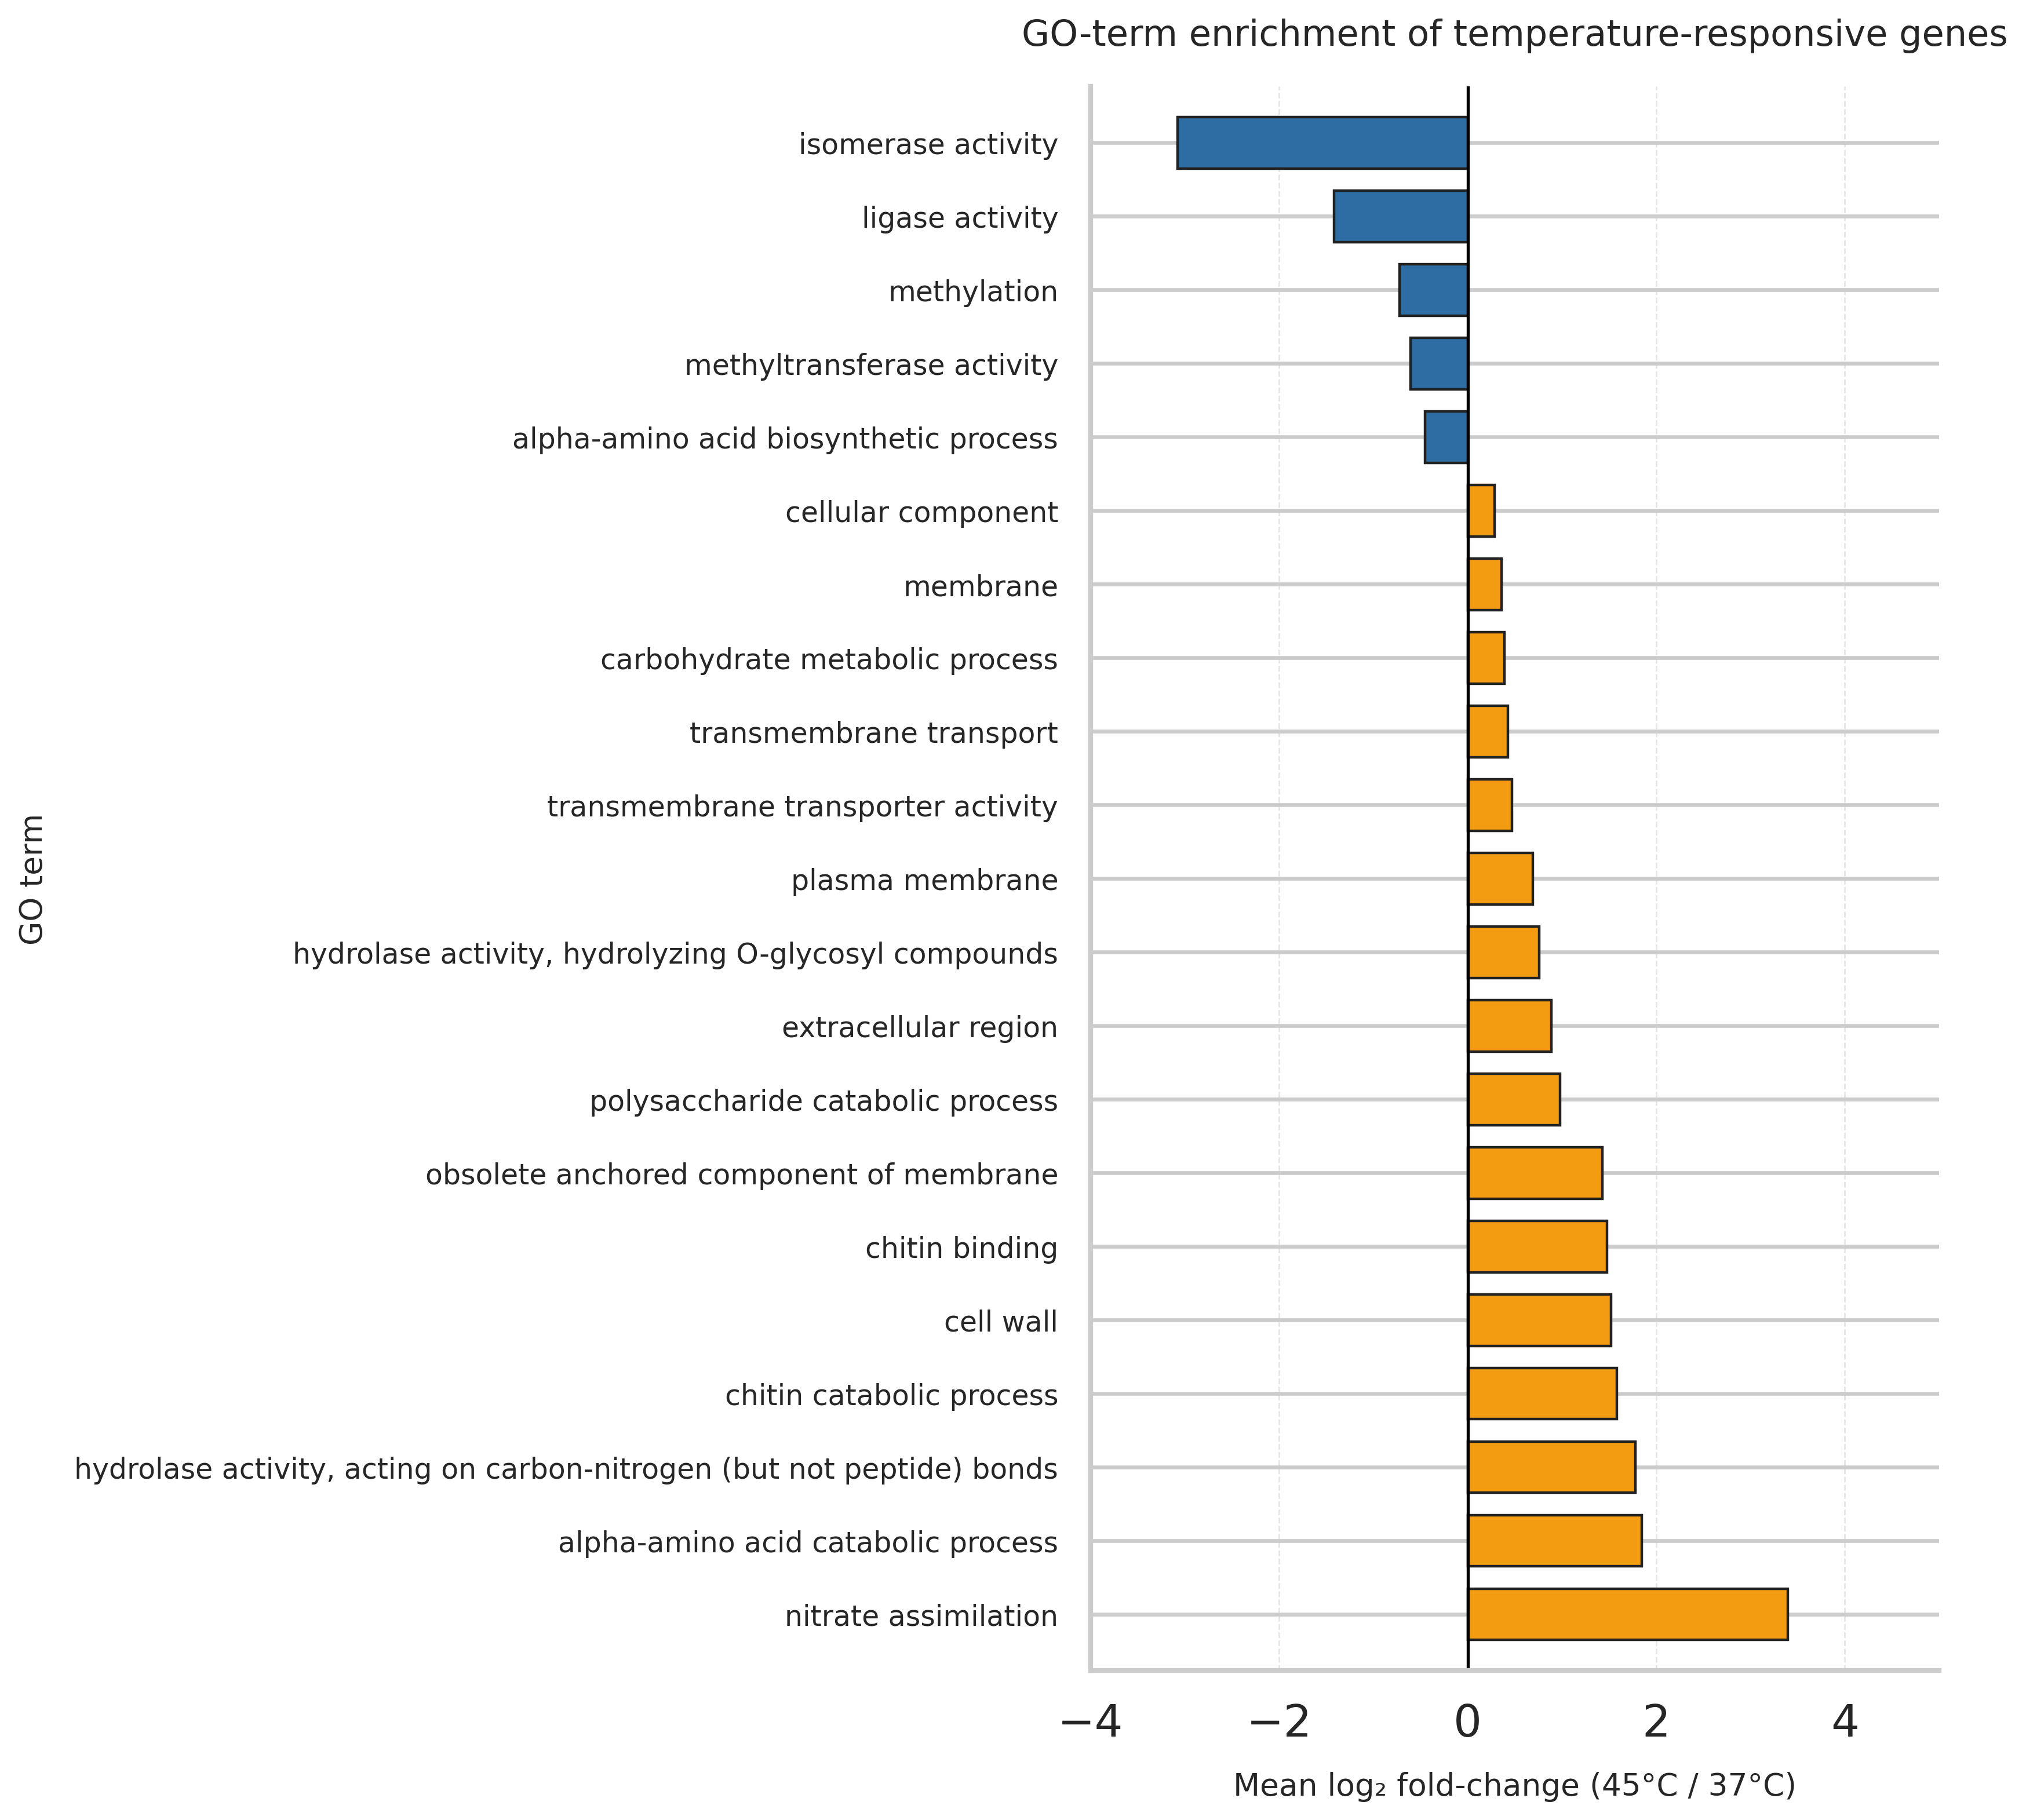

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

FC_COL = "Observed_Mean_log2FoldChange"

# --- Sort so negatives at top, positives at bottom ---
df = df.sort_values(FC_COL, ascending=True).copy()
desc = df["Description"].astype(str).tolist()
vals = df[FC_COL].to_numpy()

# Colors by direction (customizable)
colors = np.where(vals >= 0, "#f39c12", "#2e6da4")  # orange / steel blue
edge = "#222222"

# --- Figure setup ---
bar_height = 0.7
h = max(6, 0.5 * len(df))
fig, ax = plt.subplots(figsize=(11, h), dpi=320)

# Horizontal bars
ypos = np.arange(len(df))
ax.barh(
    ypos, vals,
    height=bar_height,
    color=colors,
    edgecolor=edge,
    linewidth=1.0
)

# Zero line + x-grid
ax.axvline(0, color="black", linewidth=1.2)
ax.xaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.set_axisbelow(True)

# --- Custom x-axis limit ---
ax.set_xlim(-4, 5)   # ← adjust manually (e.g. -2.5, 2.5 or -4, 4)

# Y labels & spacing
ax.set_yticks(ypos)
ax.set_yticklabels(desc, fontsize=11)
ax.invert_yaxis()
ax.margins(y=0.02)

# Labels & title
ax.set_xlabel("Mean log₂ fold-change (45°C / 37°C)", fontsize=12, labelpad=10)
ax.set_ylabel("GO term", fontsize=12, labelpad=10)
ax.set_title("GO-term enrichment of temperature-responsive genes", fontsize=14, pad=16)

# Legend on top
handles = [
    Patch(facecolor="#2e6da4", edgecolor=edge, label="Down @45°C"),
    Patch(facecolor="#f39c12", edgecolor=edge, label="Up @45°C"),
]
#ax.legend(
    #handles=handles, title=None, frameon=False, ncol=2,
    #loc="upper center", bbox_to_anchor=(0.5, 1.02), borderaxespad=0.0
#)

# Clean spines and layout
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("GO_terms_enrichment.png", dpi=400, bbox_inches="tight")
plt.savefig("GO_terms_enrichment.svg", bbox_inches="tight")
plt.show()
